## Code to save output of vh, uh and h along isopycnals for Southern Ocean

using xgcm conservative binning, described at: https://xgcm.readthedocs.io/en/latest/transform.html

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob
import cmocean.cm as cmocean
#from gsw import SA_from_SP, p_from_z, sigma1
import xgcm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

Set up some parameters and open cluster.

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36965 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
# #### get run count argument that was passed to python script #### (for PBS script)
# import sys
# run_count = int(sys.argv[1])


In [19]:
run_count = 1

In [20]:
if run_count<10:
    month = '0'+str(run_count)
elif run_count ==10:
    month = '10'
elif run_count ==11:
    month = '11'
elif run_count ==12:
    month = '12'
month

'01'

In [21]:
year = '2170'
expt = '01deg_jra55v13_ryf9091'

time_slice= year + '-' + month
start_time = year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
## FULL SO latitude range##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)



In [22]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 869 ms, sys: 91.8 ms, total: 961 ms
Wall time: 6.99 s


### Load quantities


Load daily vhrho, uhrho, dzt and density for the year chosen and select latitude/longitude region.

In [23]:
%%time

# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
vhrho = cc.querying.getvar(expt,'vhrho_nt',session,start_time=start_time, end_time=end_time)
uhrho = cc.querying.getvar(expt,'uhrho_et',session,start_time=start_time, end_time=end_time)

# select latitude range and this month:
vhrho = vhrho.sel(yt_ocean=lat_range_big).sel(time=time_slice)
uhrho = uhrho.sel(yt_ocean=lat_range).sel(time=time_slice)


CPU times: user 4.11 s, sys: 327 ms, total: 4.44 s
Wall time: 10.3 s


Since vh_rho at northern edge of cell and uhrho at eastern edge, need to interpolate to tracer grid centre so that correct binning occurs, as density is in centre of t cell. Hence, interpolate uhrho in x direction and interpolate vhrho in y direction. uhrho is easy because it is periodic bouncaries. For vhrho, just include a latitude coordinate above and below and remove later.

### Load density and dzt

In [24]:
%%time

pot_rho_1 = cc.querying.getvar(expt,'pot_rho_1',session,start_time=start_time, end_time=end_time,ncfile='%daily%')
pot_rho_1 = pot_rho_1.sel(yt_ocean=lat_range).sel(time=time_slice)
time = pot_rho_1.time


CPU times: user 646 ms, sys: 123 ms, total: 770 ms
Wall time: 1.15 s


In [25]:
%%time

dzt = cc.querying.getvar(expt,'dzt',session,start_time=start_time, end_time=end_time,ncfile='%daily%')
dzt = dzt.sel(yt_ocean=lat_range_big).sel(time=time_slice)

CPU times: user 2.33 s, sys: 459 ms, total: 2.79 s
Wall time: 3.11 s


In [26]:
%%time

st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1)


CPU times: user 421 ms, sys: 41.1 ms, total: 462 ms
Wall time: 668 ms


In [96]:
%%time
st_edges_ocean = cc.querying.getvar(expt,'st_edges_ocean',session,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean},axis=[1,2])

# import bathymetry:
ht = cc.querying.getvar(expt,'ht',session,n=1)
ht = ht.sel(yt_ocean = lat_range)

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)

CPU times: user 1.15 s, sys: 942 ms, total: 2.09 s
Wall time: 2.21 s


### define *EDGE* of bins and get rid of NaNs

In [99]:
### original isopycnals binned onto
pot_rho_1_target_centre = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,
                                        32.3,32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])

### edges of bins for here 
pot_rho_1_target = np.array([1000, 1027.5  , 1028.5  , 1029.5  , 1030.5  , 1031.25 , 1031.7  ,
       1031.95 , 1032.05 , 1032.15 , 1032.225, 1032.275, 1032.325,
       1032.39, 1032.41 , 1032.43 , 1032.45 , 1032.47 , 1032.49 ,
       1032.505, 1032.515, 1032.525, 1032.535, 1032.545, 1032.555,
       1032.57 , 1032.59 , 1032.7  , 1032.9  , 1033.5  , 1039.5  ,
       1045.5])

In [100]:
uhrho = uhrho.fillna(0)
vhrho = vhrho.fillna(0)
dzt = dzt.fillna(0)
pot_rho_1 = pot_rho_1.fillna(0)

### calculate vertical regridding into density coordinates

First roll onto t grid, then set up xgcm regridding according to the tutorial.

In [101]:
%%time

#move uhrho and vhrho to t grid since uhrho is eastern side of cell and vhrho on northern
uhrho_t = 0.5*(uhrho+uhrho.roll(xt_ocean=1, roll_coords = False)) #this takes average of adjacent cells

vhrho_t = 0.5*(vhrho+vhrho.roll(yt_ocean=1, roll_coords = False))
vhrho_t = vhrho_t[:,:,1:-1,:] # remove the outside values as their roll is incorrect
#interpolate dzt
dzt_j = dzt
#vhrho and uhrho grids are from BAY(dzu) and BAX(dzu) NOT dzt: find these
dzt_j_right = dzt_j.roll(xt_ocean = -1, roll_coords = False)
dzt_j_up = dzt_j.roll(yt_ocean = -1,roll_coords = False)
dzt_j_up_right=dzt_j.roll(yt_ocean = -1,roll_coords = False).roll(xt_ocean = -1, roll_coords = False)
dzu = np.fmin(np.fmin(np.fmin(dzt_j,dzt_j_right),dzt_j_up),dzt_j_up_right)
#now the xgrid needs BAY(dzu) while ygrid needs BAX(dzu) so that they are on uhrho and vhrho grids. we only need to do one,
#as they are equivalent when interpolatred to t-grid. I chose to find BAX because I took dzt to have bigger lon range
dzu_e = dzu.copy()
dzu_w = dzu.roll(xt_ocean = 1, roll_coords=False)
BAX_dzu = (dzu_w+dzu_e)/2    

#as with vhrho these need to be moved to t-grid in the same way:
dzu_t = 0.5*(BAX_dzu+BAX_dzu.roll(yt_ocean=1, roll_coords = False))
dzu_t = dzu_t[:,:,1:-1,:]

ds = xr.Dataset({'vhrho_nt':vhrho,'uhrho_et':uhrho,'dzt':dzt,'pot_rho_1':pot_rho_1}) ##REMEMBER TO PUT BACK TO DZU_T!!!!!####
ds = ds.assign_coords({'st_edges_ocean':st_edges_ocean})
ds = ds.chunk({'st_edges_ocean':76,'st_ocean':75})
grid = xgcm.Grid(ds, coords={'Z':{'center':'st_ocean','outer':'st_edges_ocean'}},periodic = False)
ds['pot_rho_1_outer'] = grid.interp(ds.pot_rho_1, 'Z', boundary='extend')
ds['pot_rho_1_outer'] = ds['pot_rho_1_outer'].chunk({'st_edges_ocean':76})

vhrho_transformed_cons = grid.transform(ds.vhrho_nt,
                                  'Z',
                                  pot_rho_1_target,
                                  method='conservative',
                                  target_data=ds.pot_rho_1_outer)
uhrho_transformed_cons = grid.transform(ds.uhrho_et,
                                  'Z',
                                  pot_rho_1_target,
                                  method='conservative',
                                  target_data=ds.pot_rho_1_outer)

dzu_transformed_cons = grid.transform(ds.dzt,
                                  'Z',
                                  pot_rho_1_target,
                                  method='conservative',
                                  target_data=ds.pot_rho_1_outer)

CPU times: user 2.84 s, sys: 148 ms, total: 2.98 s
Wall time: 2.96 s


In [102]:
dzu_transformed_cons

,Array,Chunk
Bytes,7.86 GiB,14.19 MiB
Shape,"(31, 610, 3600, 31)","(1, 300, 400, 31)"
Count,1930955 Tasks,837 Chunks
Type,float32,numpy.ndarray


In [91]:
### change name to fit previous bins
dzu_transformed_cons = dzu_transformed_cons.rename({'pot_rho_1_outer':'isopycnal_bins'})
dzu_transformed_cons = dzu_transformed_cons.chunk({'time':5})
h_new = dzu_transformed_cons

#### Load previously binned (old method) binned dzt, and ht and eta_t from cosima cookbook

In [74]:
h_old = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_saving_energy_terms_h_binned_2170-01_dzt.nc').h_binned
#h_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_saving_energy_terms_h_binned_2170-01_xgcm.nc').h_binned



In [79]:
ht= cc.querying.getvar(expt,'ht',session,n=1)
ht = ht.sel(yt_ocean = lat_range)
eta_t = cc.querying.getvar(expt,'eta_t',session,ncfile='%daily%',start_time=start_time, end_time=end_time)
eta_t = eta_t.sel(yt_ocean=lat_range, time=time_slice)#slice(start_time,end_time))

Text(0.5, 1.0, 'comparing the ocean depth at one longitude')

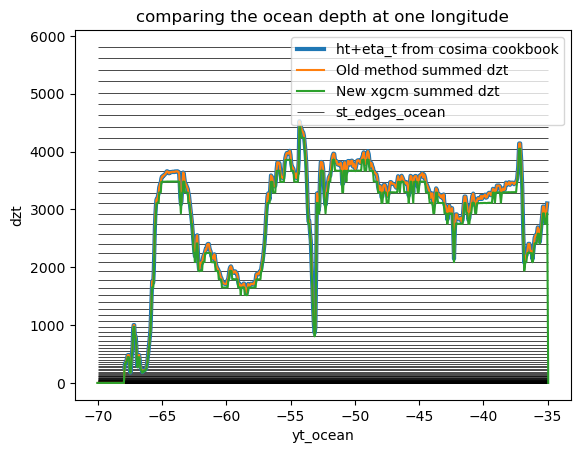

In [98]:
(ht.isel(xt_ocean=5)+eta_t.isel(xt_ocean = 5, time =10)).plot(linewidth = 3, label = 'ht+eta_t from cosima cookbook')
h_old.isel(xt_ocean = 5, time =10).sum('isopycnal_bins').plot(label = 'Old method summed dzt')
h_new.isel(xt_ocean = 5,time=10).sum('isopycnal_bins').plot(label = 'New xgcm summed dzt')
plt.hlines(st_edges_ocean.values, -70,-35, color = 'k', linewidth=0.5, label = 'st_edges_ocean')
plt.legend()
plt.title('comparing the ocean depth at one longitude')

# old method dzt is pretty much exact (see blue line behind orange line), new method is off regardless of choice of bins.

It is off because of partial cells - you can see how the green plateaus at the st_edges_ocean values. The xgcm method requires inputting st_edges_ocean (a 1D array) BUT if you account for partial cells (the array calculated from st_edges and ht) then it really has x and y variability too depending on topography. Sooooo I don't know how to fix it.